# Allora Forge Signal Miner

This notebook with help you get started with a randomized grid search,
looking for parameters over a grid of possible values.

## In this notebook you will quickly be able to:

  1. Load training and validation, and test data.
  2. Initialize, train and evaluate a variety of LightGBM models.
  3. Choose the best model, and retrain on all the data.
  4. Package your predict function into a `.pkl` file
  5. (TODO: Run your worker to deliver inference to the network)

## What you will need

  1. Allora Data API Key (go to: https://developer.allora.network/, register and generate key.)
  2. (Allora Network Wallet Address for live predictions) - under construction
  3. (Forge Competition Topic ID for live predictions) - under construction



In [ ]:
'''
Install all necessary packages
'''

%pip install git+https://github.com/allora-network/allora-forge-ml-workflow.git
%pip install lightgbm scikit-learn pandas numpy matplotlib dill 

  Cloning https://github.com/allora-network/allora-forge-ml-workflow.git to /tmp/pip-req-build-fwpvz5hl
  Running command git clone --filter=blob:none --quiet https://github.com/allora-network/allora-forge-ml-workflow.git /tmp/pip-req-build-fwpvz5hl
  Resolved https://github.com/allora-network/allora-forge-ml-workflow.git to commit f6cea8e8894e4789c7550bd424f0fdd1bbf27de1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [1]:
'''
Write Imports
'''

from allora_ml_workflow import AlloraMLWorkflow #Allora Forge
from allora_ml_workflow import get_api_key
import lightgbm as lgb
import pandas as pd
import cloudpickle
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import ParameterSampler

In [2]:
'''
API KEY
This gives you access to OHLCV (open, high, low, close, volume) candle data through the workflow

To get your API key, go to https://developer.allora.network/, 
create an account, and generate a new API key.

'''

api_key = get_api_key()

In [13]:
'''
Get Allora Forge Competition Info
'''

import requests
import pandas as pd

API_KEY = api_key
url = "https://api.allora.network/v2/allora/allora-testnet-1/topics"

headers = {"x-api-key": API_KEY}
response = requests.get(url, headers=headers)
data = response.json()

# Extract the list of topics
topics = data["data"]["topics"]

# Convert to DataFrame
topic_df = pd.DataFrame(topics)

In [14]:
[ k for k in data['data'].keys() ]

['topics', 'continuation_token']

In [15]:
topic_df.sort_values(by="topic_id").tail(3)

,topic_id,topic_name,description,epoch_length,ground_truth_lag,loss_method,worker_submission_window,worker_count,reputer_count,total_staked_allo,total_emissions_allo,is_active,is_endorsed,forge_competition_id,forge_competition_start_date,forge_competition_end_date,latest_network_inference,updated_at
39,63,1 day ETH/USD Log-Return Prediction,None,60,17280,zptae,50,32,3,0.300095,0.000001,True,False,17.0,2025-07-16T18:00:00.000Z,2025-08-16T18:00:00.000Z,{'combined_value': '0.010269541114663800649173...,2025-08-20T20:24:59.662Z
29,64,8h BTC/USD Log-Return Prediction (5min Updates),None,54,5142,zptae,50,0,0,0.000000,0.000000,False,False,18.0,2025-08-20T20:00:00.000Z,2025-09-20T20:00:00.000Z,None,2025-08-20T20:25:29.662Z
45,65,8h BTC/USD Log-Return Prediction (2h Updates),None,1286,5142,zptae,600,0,0,0.000000,0.000000,False,False,19.0,2025-08-20T20:00:00.000Z,2025-09-20T20:00:00.000Z,None,2025-08-20T18:42:49.662Z


In [16]:
'''
Setup

These variables define the ticker data to retrieve, and the feature and targets sizes.

hours_needed: 
'''
# tickers = ["btcusd", "ethusd", "solusd"]
tickers = ["ethusd"]#, "ethusd", "solusd"]
hours_needed = 3*24             # Number of historical hours for feature lookback window
number_of_input_candles = 24    # Number of candles for input features
target_length = 8            # Number of hours into the future for target

# Instantiate the workflow
workflow = AlloraMLWorkflow(
    data_api_key=api_key,
    tickers=tickers,
    hours_needed=hours_needed,
    number_of_input_candles=number_of_input_candles,
    target_length=target_length
)

In [17]:
# Get training, validation, and test data
X_train, y_train, X_val, y_val, X_test, y_test = workflow.get_train_validation_test_data(
    from_month="2021-01",
    validation_months=6,
    test_months=6
)

# Example: Check the shapes of the datasets
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Processing 5-minute bars for ethusd
Computing target
Extracting features
Saving data to data_ethusd_2021-01_val6_test6_candles24.pkl
Training set: (377864, 151) (377864,)
Validation set: (50986, 151) (50986,)
Test set: (50144, 151) (50144,)


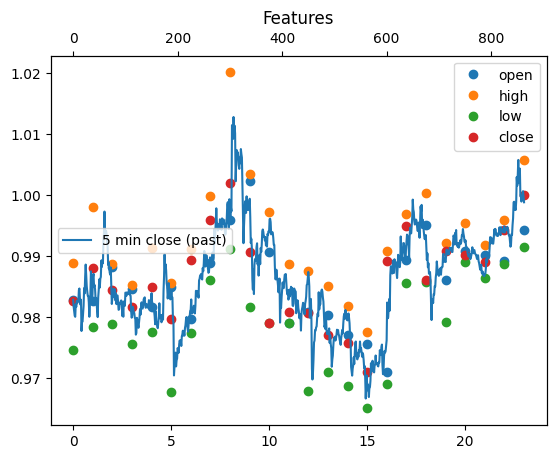

In [18]:
'''
Visualize Features and Past Price Process

The Features are the input data used for training the model, 
while the Past Price Process shows the historical price movements of the asset.

Currently, the features are just the normalized OHLCV (open, high, low, close, volume) data for the last 24 hours.
However, you can choose a different history length by changing the `hours_needed` variable above, 
or the number of candles by changing `number_of_input_candles`.

'''

eth_data = X_train.loc[(slice(None), 'ethusd'), :]
data_idx = -10000  # which data point to visualize

# Plot features based on data_idx
plt.plot([eth_data.iloc[data_idx][f"feature_open_{i}"] for i in range(number_of_input_candles)], 'o', label="open")
plt.plot([eth_data.iloc[data_idx][f"feature_high_{i}"] for i in range(number_of_input_candles)], 'o', label="high")
plt.plot([eth_data.iloc[data_idx][f"feature_low_{i}"] for i in range(number_of_input_candles)], 'o', label="low")
plt.plot([eth_data.iloc[data_idx][f"feature_close_{i}"] for i in range(number_of_input_candles)], 'o', label="close")
plt.legend()

# Plot past price process based on data_idx
plt.twiny()
plt.plot(
    (eth_data.iloc[data_idx - (hours_needed * 12):data_idx]['close'].values) / eth_data.iloc[data_idx]['close'],
    label="5 min close (past)"
)
plt.legend(loc='center left')
plt.title("Features")
plt.show()

In [ ]:
'''
LightGBM Randomized Grid Search

This section performs a randomized grid search to optimize hyperparameters for a LightGBM model.

The code generate random combinations of hyperparameters from a defined search space, 
trains a LightGBM model for each combination, 
and evaluates the model's performance on validation and test datasets,
storing the results for comparison.
'''

n_random_samples = 50  # Number of random parameter settings to evaluate

#define feature columns
feature_cols = [f for f in list(X_train) if 'feature' in f]

# Define custom evaluation metric for correlation
def corr_eval_metric(y_true, y_pred):
    corr = np.corrcoef(y_true, y_pred)[0, 1]
    # LightGBM expects: (eval_name, eval_result, is_higher_better)
    return 'corr', corr, True

# Define search space
param_space = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1],
    'L2_reg': [1, 10, 100, 1000],
    'min_child_weight': [10, 100, 1000],
    'num_bins': [8, 16, 32, 64],
    'num_leaves': [4,8,16,32,64],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
}

# Initialize a list to store results
results = []

# Randomly sample parameter combinations
random_param_combinations = list(ParameterSampler(param_space, n_iter=n_random_samples, random_state=42))

for params in random_param_combinations:
    model = lgb.LGBMRegressor(
        n_estimators=2000,
        learning_rate=params['learning_rate'],
        max_depth=params['max_depth'],
        num_leaves=params['num_leaves'],
        reg_lambda=params['L2_reg'],
        min_child_weight=params['min_child_weight'],
        max_bin=params['num_bins'],
        colsample_bytree=params['colsample_bytree']
    )
    
    # Fit model on training data and validate
    model.fit(
        X_train[feature_cols], y_train,
        eval_set=[(X_val[feature_cols], y_val)],
        eval_metric=corr_eval_metric,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100, verbose=False)
        ]
    )
    
    # Get predictions on validation set
    val_preds = model.predict(X_val[feature_cols])
    val_corr = np.corrcoef(y_val, val_preds)[0, 1]
    val_directional_accuracy = np.mean((np.sign(val_preds) == np.sign(y_val)).astype(int))
    
    # Get the best iteration
    best_iteration = model.best_iteration_
    
    # Retrain the model on training + validation data
    retrained_model = lgb.LGBMRegressor(
        n_estimators=best_iteration,
        learning_rate=params['learning_rate'],
        max_depth=params['max_depth'],
        num_leaves=params['num_leaves'],
        reg_lambda=params['L2_reg'],
        min_child_weight=params['min_child_weight'],
        max_bin=params['num_bins'],
        colsample_bytree=params['colsample_bytree']
    )
    retrained_model.fit(
        pd.concat([X_train[feature_cols], X_val[feature_cols]]), 
        pd.concat([y_train, y_val])
    )
    
    # Evaluate on the test set
    test_preds = retrained_model.predict(X_test[feature_cols])
    test_corr = np.corrcoef(y_test, test_preds)[0, 1]
    test_directional_accuracy = np.mean((np.sign(test_preds) == np.sign(y_test)).astype(int))
    
    # Record results
    results.append({
        'n_estimators': best_iteration,
        'max_depth': params['max_depth'],
        'learning_rate': params['learning_rate'],
        'L2_reg': params['L2_reg'],
        'min_child_weight': params['min_child_weight'],
        'num_bins': params['num_bins'],
        'num_leaves': params['num_leaves'],
        'colsample_bytree': params['colsample_bytree'],
        'val_corr': val_corr,
        'val_directional_accuracy': val_directional_accuracy,
        'test_corr': test_corr,
        'test_directional_accuracy': test_directional_accuracy
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
print(results_df)



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9088
[LightGBM] [Info] Number of data points in the train set: 377864, number of used features: 142
[LightGBM] [Info] Start training from score 0.000298
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9088
[LightGBM] [Info] Number of data points in the train set: 428850, number of used features: 142
[LightGBM] [Info] Start training from score 0.000272
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1136
[LightGBM] [Info] Number of data points in the train

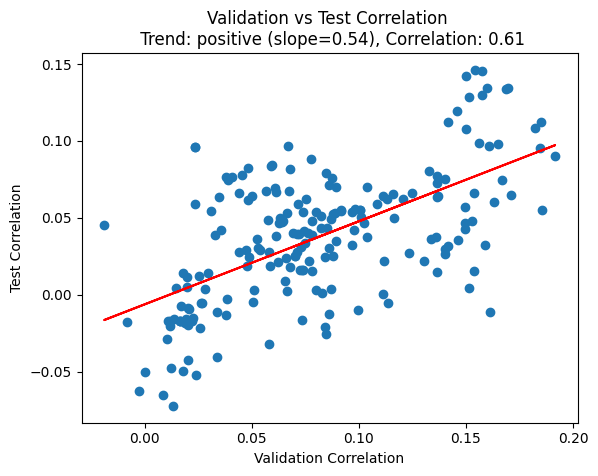

In [21]:
'''
Inspect Results

Compare validation and test scores, making sure higher validation scores correspond to higher test scores.

This will give you confidence that the model is generalizing well and not overfitting to the validation set.
Even though, notice that there is no guarantee that the best model on validation
will be the best on test, but it is a good indicator.

If you see a weak correlation between validation and test scores,
something like a round ball, or a negative trend,
it indicates that the model is not generalizing well,
and you should use caution when selecting hyperparameters based on validation performance.
'''

plt.scatter(results_df['val_corr'], results_df['test_corr'])
plt.xlabel('Validation Correlation')
plt.ylabel('Test Correlation')


#plot linear fit line
m, b = np.polyfit(results_df['val_corr'], results_df['test_corr'], 1)
trend = 'positive' if m > 0 else 'negative'
performance_correlation = np.corrcoef(results_df['val_corr'], results_df['test_corr'])[0, 1]
plt.title(f'Validation vs Test Correlation \n Trend: {trend} (slope={m:.2f}), Correlation: {performance_correlation:.2f}')

plt.plot(results_df['val_corr'], m*results_df['val_corr'] + b, color='red')
plt.show()

In [22]:
results_df

,n_estimators,max_depth,learning_rate,L2_reg,min_child_weight,num_bins,num_leaves,colsample_bytree,val_corr,val_directional_accuracy,test_corr,test_directional_accuracy
0,2,4,0.0010,10,10,64,4,0.6,0.136470,0.512847,0.063844,0.537572
1,2,7,0.0010,1,100,8,4,0.5,0.022251,0.512847,-0.016747,0.537572
2,470,7,0.0100,100,1000,64,32,1.0,0.185101,0.494822,0.112127,0.513561
3,1063,9,0.0100,1000,100,32,16,0.7,0.149370,0.504688,0.042777,0.496271
4,1,10,0.0001,1,10,8,64,1.0,-0.008157,0.512847,-0.017526,0.537572
...,...,...,...,...,...,...,...,...,...,...,...,...
195,1,5,0.0001,100,100,16,8,0.9,0.070379,0.512847,0.025061,0.537572
196,183,9,0.0100,1,10,32,64,0.8,0.113368,0.503570,0.062465,0.517888
197,138,10,0.1000,100,10,8,8,0.5,0.076540,0.494371,0.021715,0.510629
198,1,3,0.0001,100,10,8,32,0.7,0.020015,0.512847,0.011342,0.537572


In [1]:
'''
Take a look at validation and test returns
'''
best_index = (results_df['val_corr'] + results_df['test_corr']).idxmax()
best_params = results_df.loc[best_index]
print("Best Hyperparameters:\n", best_params)
best_model = lgb.LGBMRegressor(
    n_estimators=int(best_params['n_estimators']),
    learning_rate=best_params['learning_rate'],
    max_depth=int( best_params['max_depth'] ),
    num_leaves=int( best_params['num_leaves'] ),
    reg_lambda=best_params['L2_reg'],
    min_child_weight=int(best_params['min_child_weight']),
    max_bin=int(best_params['num_bins'])
)
best_model.fit(
    pd.concat([X_train[feature_cols],]), 
    pd.concat([y_train, ]),
)

toy_preds = best_model.predict(X_val[feature_cols])

NameError: name 'results_df' is not defined

In [23]:
'''
Choose Model is Higher Average validation and test correlation

Retrain the model on all the data, using the best hyperparameters found.
'''
best_index = (results_df['val_corr'] + results_df['test_corr']).idxmax()
best_params = results_df.loc[best_index]
print("Best Hyperparameters:\n", best_params)
best_model = lgb.LGBMRegressor(
    n_estimators=int(best_params['n_estimators']),
    learning_rate=best_params['learning_rate'],
    max_depth=int( best_params['max_depth'] ),
    num_leaves=int( best_params['num_leaves'] ),
    reg_lambda=best_params['L2_reg'],
    min_child_weight=int(best_params['min_child_weight']),
    max_bin=int(best_params['num_bins'])
)
best_model.fit(
    pd.concat([X_train[feature_cols], X_val[feature_cols], X_test[feature_cols]]), 
    pd.concat([y_train, y_val, y_test]),
)

Best Hyperparameters:
 n_estimators                  641.000000
max_depth                       9.000000
learning_rate                   0.010000
L2_reg                       1000.000000
min_child_weight               10.000000
num_bins                       64.000000
num_leaves                     16.000000
colsample_bytree                0.500000
val_corr                        0.169537
val_directional_accuracy        0.493940
test_corr                       0.134715
test_directional_accuracy       0.511627
Name: 80, dtype: float64
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9088
[LightGBM] [Info] Number of data points in the train set: 478994, number of used features: 142
[LightGBM] [Info] Start training from score 0.000382


LGBMRegressor(learning_rate=0.01, max_bin=64, max_depth=9, min_child_weight=10,
              n_estimators=641, num_leaves=16, reg_lambda=1000.0)

In [34]:
'''
Package the model and predict function
'''

# Final predict function
def predict() -> pd.Series:
    live_features = workflow.get_live_features("btcusd")
    preds = best_model.predict(live_features)
    return float( np.array( preds ) [0] )

# Pickle the function
with open("predict.pkl", "wb") as f:
    cloudpickle.dump(predict, f)

In [35]:
'''
Test Live Predictions

This function simulates a live prediction scenario by loading the pickled function,
calling it, and printing the prediction time and result.
'''



# Load the pickled predict function
with open("predict.pkl", "rb") as f:
    predict_fn = cloudpickle.load(f)

# Call the function and get predictions
tic = time.time()
prediction = predict_fn()
toc = time.time()

print("predict time: ", (toc - tic) )
print("prediction: ", prediction )


Live Mode Bars:                                       open           high            low  \
date                                                                     
2025-08-20 22:09:00+00:00  114316.685435  114324.779047  114227.583605   
2025-08-20 22:14:00+00:00  114295.197013  114363.789829  114256.206363   
2025-08-20 22:19:00+00:00  114211.282450  114415.958275  114211.282450   
2025-08-20 22:24:00+00:00  114345.281611  114426.421005  114343.903092   
2025-08-20 22:29:00+00:00  114486.622298  114504.156451  114368.897481   

                                   close     volume  trades_done  
date                                                              
2025-08-20 22:09:00+00:00  114318.154675  25.431168         1517  
2025-08-20 22:14:00+00:00  114285.944910  21.628642         1639  
2025-08-20 22:19:00+00:00  114363.629441  31.555252         1792  
2025-08-20 22:24:00+00:00  114420.073867  18.173295         1388  
2025-08-20 22:29:00+00:00  114416.057483  13.618489         1

In [36]:
import shutil

topic_ids = [65, 64]

#copy predict.pkl to worker/predict_{topic_id} for all in topic_ids
for topic_id in topic_ids:
    shutil.copy("predict.pkl", f"worker/predict_{topic_id}.pkl")
